In [1]:
# ------------------- IMPORT LIBRARIES -------------------
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ------------------- LOAD DATA -------------------
events_df = pd.read_csv("near_collision_master.csv")
ports_gdf = gpd.read_file("DATA/[C1] Ports of Brittany/port.shp")

# Fix MultiPoint geometries
ports_gdf["geometry"] = ports_gdf["geometry"].apply(
    lambda geom: geom.geoms[0] if geom.geom_type == "MultiPoint" else geom
)

# ------------------- CONVERT TO GEODATAFRAMES -------------------
events_gdf = gpd.GeoDataFrame(
    events_df,
    geometry=[Point(xy) for xy in zip(events_df["lon_1"], events_df["lat_1"])],
    crs="EPSG:4326"
)

# Both to same CRS
ports_gdf = ports_gdf.to_crs("EPSG:4326")

# ------------------- PROJECT TO METERS FOR SPATIAL INDEX -------------------
events_proj = events_gdf.to_crs(epsg=3857)
ports_proj = ports_gdf.to_crs(epsg=3857)

# ------------------- FAST NEAREST NEIGHBOR SEARCH -------------------
print("Finding nearest port for each event (using spatial index)...")

joined = gpd.sjoin_nearest(
    events_proj, ports_proj,
    how="left", distance_col="port_distance_m"
)

# Convert port distance to km
joined["port_distance_km"] = joined["port_distance_m"] / 1000

# ------------------- CLASSIFY AS HARBOR OR OPEN SEA -------------------
harbor_radius_km = 5
joined["region_type"] = joined["port_distance_km"].apply(
    lambda d: "harbor" if d <= harbor_radius_km else "open_sea"
)

# ------------------- SAVE RESULTS -------------------
output_cols = [
    "time_window", "mmsi_1", "mmsi_2", "lat_1", "lon_1", "lat_2", "lon_2",
    "speed_1", "speed_2", "course_1", "course_2",
    "distance_m",               # distance between ships
    "port_distance_m", "port_distance_km",  # distance to nearest port
    "region_type"
]

joined[output_cols].to_csv("classified_near_collisions.csv", index=False)

print("✅ Classification complete! Saved as 'classified_near_collisions.csv'")
print(joined["region_type"].value_counts())


Finding nearest port for each event (using spatial index)...
✅ Classification complete! Saved as 'classified_near_collisions.csv'
harbor      343088
open_sea    333956
Name: region_type, dtype: int64


In [2]:
import pandas as pd

# Load classified data
df_classified = pd.read_csv("classified_near_collisions.csv")

# Show first few rows
print(df_classified.head())


           time_window     mmsi_1     mmsi_2      lat_1     lon_1      lat_2  \
0  2015-09-30 22:18:00  228854000  228931000  48.118610 -4.415707  48.121580   
1  2015-09-30 22:19:00  228133000  228854000  48.117535 -4.424553  48.118410   
2  2015-09-30 22:20:00  228854000  228133000  48.118250 -4.424275  48.117233   
3  2015-09-30 22:21:00  228133000  228854000  48.116974 -4.433182  48.118060   
4  2015-09-30 22:24:00  228854000  228133000  48.117516 -4.441568  48.116100   

      lon_2  speed_1  speed_2  course_1  course_2  distance_m  \
0 -4.419288     10.5      8.9     274.6      78.5  424.450297   
1 -4.420028     10.6     10.4     263.1     269.3  350.704813   
2 -4.429567     10.4     10.7     261.4     264.9  409.924222   
3 -4.428580     10.7     10.4     264.9     268.4  363.300903   
4 -4.446808     10.8     10.7     261.5     264.3  420.718312   

   port_distance_m  port_distance_km region_type  
0      9035.900132          9.035900    open_sea  
1      9884.280872        

In [3]:
import matplotlib.pyplot as plt

# Separate harbor and open-sea events
harbor_events = df_classified[df_classified["region_type"] == "harbor"]
open_sea_events = df_classified[df_classified["region_type"] == "open_sea"]



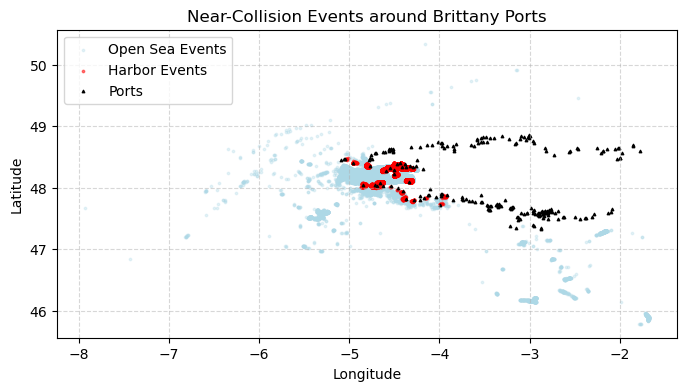

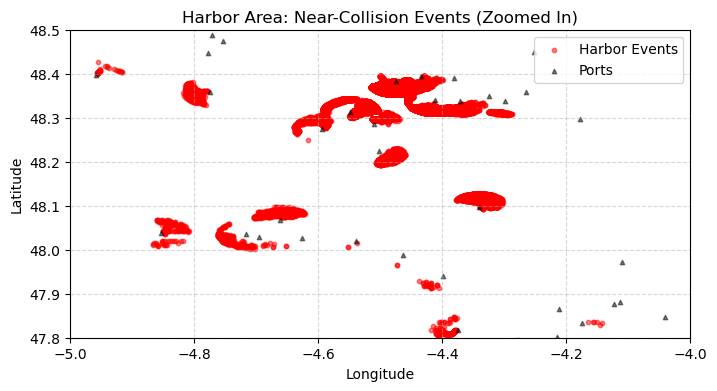

In [4]:
# Plot Harbor Events + Ports
plt.figure(figsize=(8, 4))
plt.scatter(open_sea_events["lon_1"], open_sea_events["lat_1"], 
            c='lightblue', alpha=0.3, s=3, label='Open Sea Events')
plt.scatter(harbor_events["lon_1"], harbor_events["lat_1"], 
            c='red', alpha=0.5, s=3, label='Harbor Events')

# Add port locations
plt.scatter(ports_gdf.geometry.x, ports_gdf.geometry.y, 
            c='black', marker='^', s=3, label='Ports')

plt.title("Near-Collision Events around Brittany Ports")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Zoomed-in version for Harbor Area
plt.figure(figsize=(8, 4))
plt.scatter(harbor_events["lon_1"], harbor_events["lat_1"], 
            c='red', alpha=0.5, s=10, label='Harbor Events')
plt.scatter(ports_gdf.geometry.x, ports_gdf.geometry.y, 
            c='black', marker='^',alpha=0.5, s=10, label='Ports')

plt.title("Harbor Area: Near-Collision Events (Zoomed In)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Optional: you can zoom manually if you know harbor coordinates
plt.xlim(-5, -4)   # Adjust longitude range
plt.ylim(47.8, 48.5)  # Adjust latitude range
plt.show()


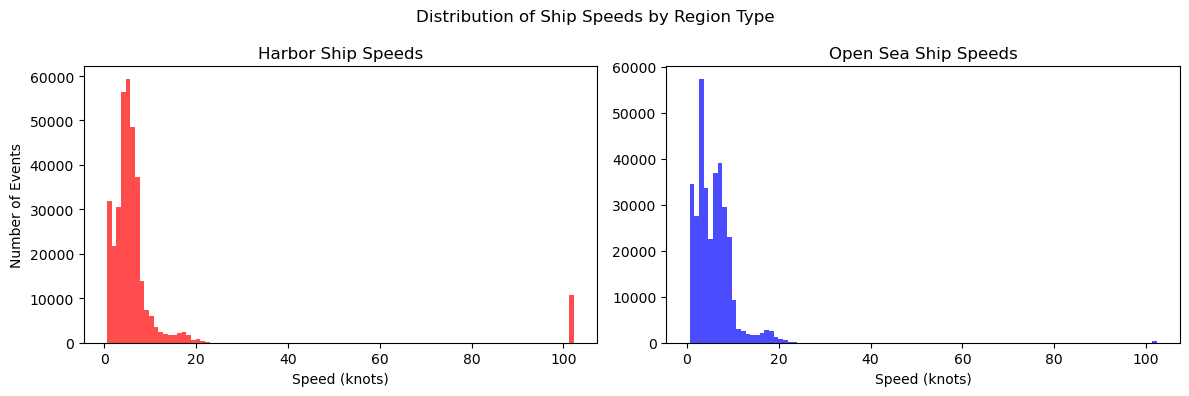

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
axes[0].hist(harbor_events["speed_1"], bins=100, color='red', alpha=0.7)
axes[0].set_title("Harbor Ship Speeds")
axes[0].set_xlabel("Speed (knots)")
axes[0].set_ylabel("Number of Events")

axes[1].hist(open_sea_events["speed_1"], bins=100, color='blue', alpha=0.7)
axes[1].set_title("Open Sea Ship Speeds")
axes[1].set_xlabel("Speed (knots)")

plt.suptitle("Distribution of Ship Speeds by Region Type")
plt.tight_layout()
plt.show()


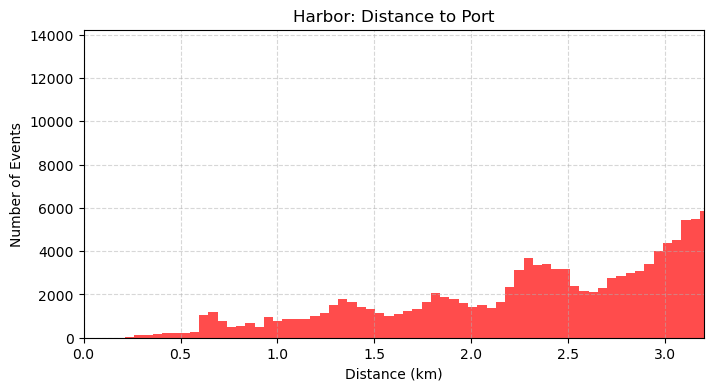

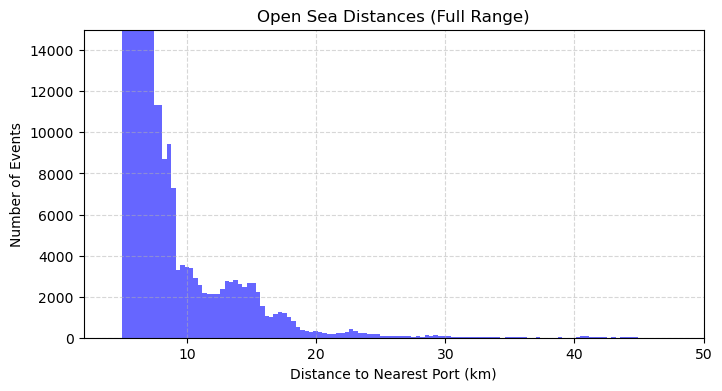

In [6]:
# Harbor events
plt.figure(figsize=(8,4))
plt.hist(harbor_events["port_distance_km"], bins=100, color='red', alpha=0.7)
plt.xlim(0, 3.2)  # Harbor events are within 3 km
plt.title("Harbor: Distance to Port")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Events")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#opensea events
plt.figure(figsize=(8,4))
plt.hist(open_sea_events["port_distance_km"], bins=1000, color='blue', alpha=0.6)
plt.xlim(2, 50)
plt.ylim(0, 15000)
plt.xlabel("Distance to Nearest Port (km)")
plt.ylabel("Number of Events")
plt.title("Open Sea Distances (Full Range)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


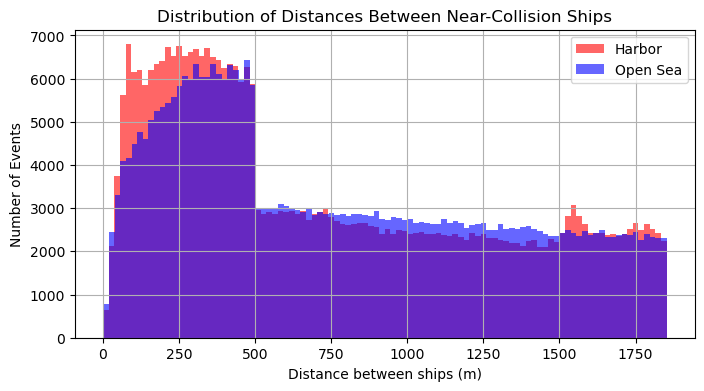

In [7]:
plt.figure(figsize=(8,4))
plt.hist(harbor_events["distance_m"], bins=100, alpha=0.6, label='Harbor', color='red')
plt.hist(open_sea_events["distance_m"], bins=100, alpha=0.6, label='Open Sea', color='blue')
plt.xlabel("Distance between ships (m)")
plt.ylabel("Number of Events")
plt.title("Distribution of Distances Between Near-Collision Ships")
plt.legend()
plt.grid(True)
plt.show()


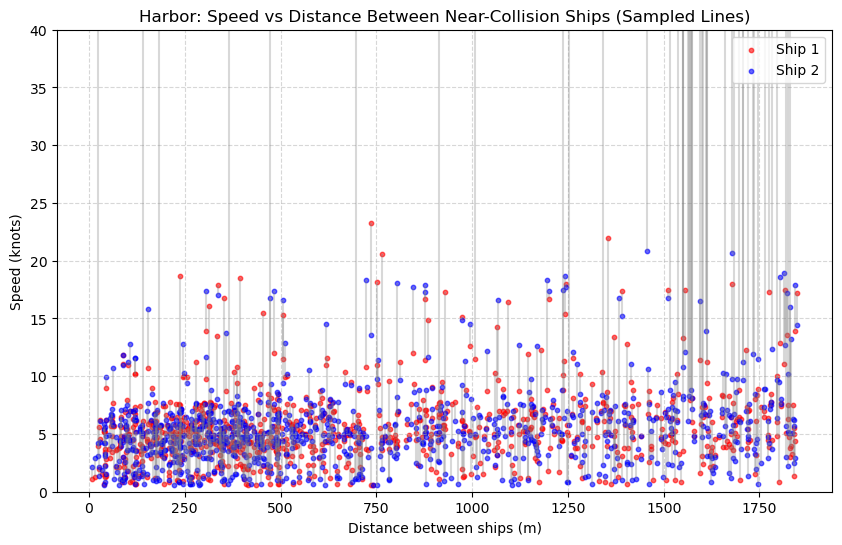

In [8]:
sample_lines = harbor_events.sample(1000, random_state=42)

plt.figure(figsize=(10,6))

# Plot lines for sampled events
plt.vlines(
    x=sample_lines["distance_m"],
    ymin=sample_lines["speed_1"],
    ymax=sample_lines["speed_2"],
    color='gray',
    alpha=0.3
)

# Scatter for all points (optional: can also sample)
plt.scatter(sample_lines["distance_m"], sample_lines["speed_1"], c='red', alpha=0.6, s=10, label='Ship 1')
plt.scatter(sample_lines["distance_m"], sample_lines["speed_2"], c='blue', alpha=0.6, s=10, label='Ship 2')

plt.ylim(0, 40)
plt.xlabel("Distance between ships (m)")
plt.ylabel("Speed (knots)")
plt.title("Harbor: Speed vs Distance Between Near-Collision Ships (Sampled Lines)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


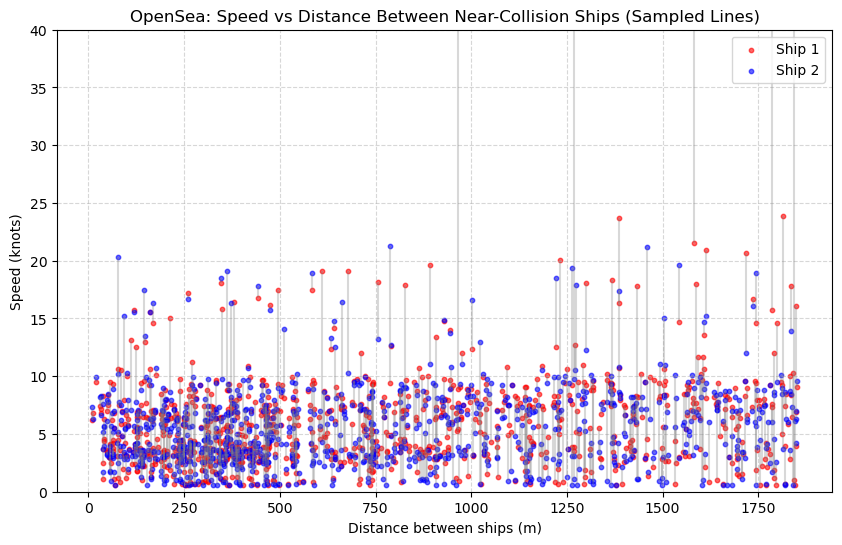

In [9]:
sample_lines = open_sea_events.sample(1000, random_state=42)

plt.figure(figsize=(10,6))

# Plot lines for sampled events
plt.vlines(
    x=sample_lines["distance_m"],
    ymin=sample_lines["speed_1"],
    ymax=sample_lines["speed_2"],
    color='gray',
    alpha=0.3
)

# Scatter for all points (optional: can also sample)
plt.scatter(sample_lines["distance_m"], sample_lines["speed_1"], c='red', alpha=0.6, s=10, label='Ship 1')
plt.scatter(sample_lines["distance_m"], sample_lines["speed_2"], c='blue', alpha=0.6, s=10, label='Ship 2')

plt.ylim(0, 40)
plt.xlabel("Distance between ships (m)")
plt.ylabel("Speed (knots)")
plt.title("OpenSea: Speed vs Distance Between Near-Collision Ships (Sampled Lines)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

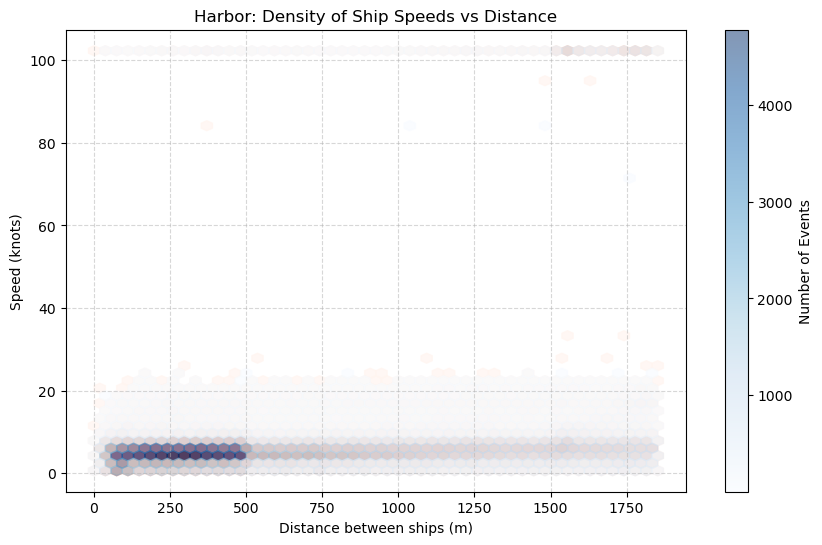

In [10]:
plt.figure(figsize=(10,6))
plt.hexbin(harbor_events["distance_m"], harbor_events["speed_1"], gridsize=50, cmap='Reds', alpha=0.7, mincnt=1)
plt.hexbin(harbor_events["distance_m"], harbor_events["speed_2"], gridsize=50, cmap='Blues', alpha=0.5, mincnt=1)
plt.colorbar(label='Number of Events')
plt.xlabel("Distance between ships (m)")
plt.ylabel("Speed (knots)")
plt.title("Harbor: Density of Ship Speeds vs Distance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


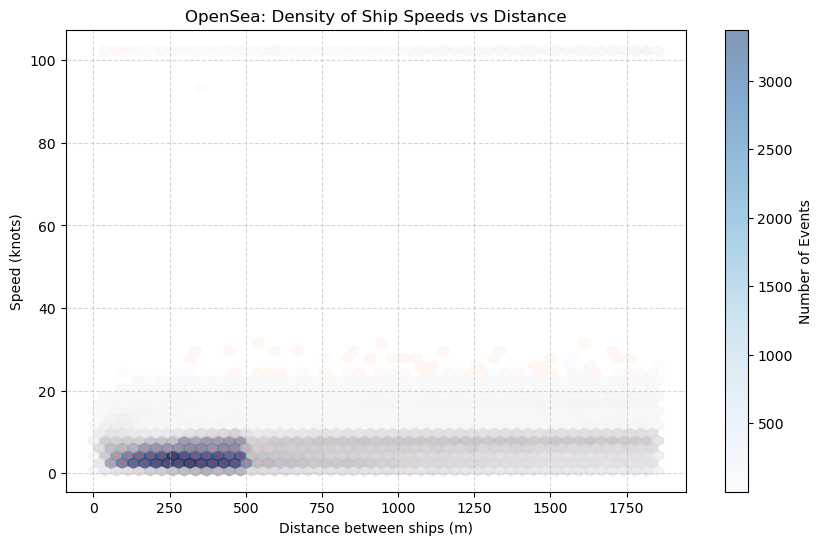

In [11]:
plt.figure(figsize=(10,6))
plt.hexbin(open_sea_events["distance_m"], open_sea_events["speed_1"], gridsize=50, cmap='Reds', alpha=0.7, mincnt=1)
plt.hexbin(open_sea_events["distance_m"], open_sea_events["speed_2"], gridsize=50, cmap='Blues', alpha=0.5, mincnt=1)
plt.colorbar(label='Number of Events')
plt.xlabel("Distance between ships (m)")
plt.ylabel("Speed (knots)")
plt.title("OpenSea: Density of Ship Speeds vs Distance")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()